In [1]:
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import glob
from natsort import natsorted
from tabulate import tabulate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Comparison of linear regression using least squares, ridge, and lasso.

In [2]:
# data_list[i][0] : dataset i X_train
# data_list[i][1] : dataset i y_train
# data_list[i][2] : dataset i X_test
# data_list[i][3] : dataset i y_test

data_list = []
for path in natsorted(glob.glob("../data/*.npz")):
    print(path)
    data = []
    with np.load(path) as f:
        for key in f.files:
            data.append(f[key])
    data_list.append(data)

../data/dataset1_dim9_Ntr5.npz
../data/dataset2_dim9_Ntr50.npz
../data/dataset3_dim9_Ntr500.npz
../data/dataset4_dim2_Ntr5.npz
../data/dataset5_dim2_Ntr15.npz
../data/dataset6_dim2_Ntr50.npz
../data/dataset7_dim2_Ntr5.npz
../data/dataset8_dim2_Ntr15.npz
../data/dataset9_dim2_Ntr50.npz
../data/example_data.npz


### (a) Given that the dimension of features is 9 (before augmentation), estimate the $w$ and try three regularization settings: [no regularization, $l_{1}$ regularization, $l_{2}$ regularization] and report the corresponding statistics.

#### i. Fill all your numerical results into the following table.
<img src="../imgs/fig1.png" alt="Drawing" style="width: 500px;" align="left"/>

In [3]:
def findBestAlpha(regressor, X, y, max_iter=None):
    '''use 5-fold cross validation to find the best alpha'''
    log2alpha = np.linspace(-10, 10, num=41)
    cv_score_mean = []
    cv_score_std = []
    for alpha in 2**log2alpha:
        estimator = regressor(alpha=alpha, max_iter=max_iter)
        cv_score = -cross_val_score(estimator=estimator, X=X, y=y,
                                    scoring='neg_mean_squared_error', cv=5)
        cv_score_mean.append(cv_score.mean())
        cv_score_std.append(cv_score.std())

    best_i = np.argmin(cv_score_mean)
    return [log2alpha[best_i], cv_score_mean[best_i], cv_score_std[best_i]]

def getResult(regressor, X_train, y_train, X_test, y_test):
    '''print weights, train mse, test mse, and sparsity'''
    regressor.fit(X_train, y_train)
    mse_train = mean_squared_error(y_train, regressor.predict(X_train))
    mse_test = mean_squared_error(y_test, regressor.predict(X_test))
    coefs = np.insert(regressor.coef_, 0, regressor.intercept_)
    return [mse_train, mse_test, len(coefs) - np.count_nonzero(np.round(coefs,3)), coefs]

In [4]:
table_list = []
for i in range(3):
    table = []
    # Least square
    res = ["Least square", "", "", ""]
    regressor_ols = LinearRegression()
    res += getResult(regressor_ols, data_list[i][0], data_list[i][1],
                     data_list[i][2], data_list[i][3])
    table.append(res)

    # LASSO
    res = ["LASSO"]
    res += findBestAlpha(
        Lasso, data_list[i][0], data_list[i][1], max_iter=4000)
    regressor_lasso = Lasso(alpha=2**res[1], max_iter=4000)
    res += getResult(regressor_lasso, data_list[i][0], data_list[i][1],
              data_list[i][2], data_list[i][3])
    table.append(res)

    # Ridge
    res = ["Ridge"]
    res += findBestAlpha(
        Ridge, data_list[i][0], data_list[i][1])

    regressor_ridge = Ridge(alpha=2**res[1])
    res += getResult(regressor_ridge, data_list[i][0], data_list[i][1],
              data_list[i][2], data_list[i][3])
    table.append(res)

    table_list.append(table)

In [5]:
for i in range(3):
    print(f"dataset {i + 1} table : ")
    headers = ["", "Best param log𝜆", "Mean of MSE", "Std of MSE",
               "MSE on train", "MSE on test", "Sparsity", "Final Weights"]
    print(tabulate(table_list[i], headers, tablefmt="grid"))
    print()

dataset 1 table : 
+--------------+-------------------+-------------------+-------------------+----------------+---------------+------------+--------------------------------------------------------------------------+
|              | Best param log𝜆   | Mean of MSE       | Std of MSE        |   MSE on train |   MSE on test |   Sparsity | Final Weights                                                            |
+==============+===================+===================+===================+================+===============+============+==========================================================================+
| Least square |                   |                   |                   |    3.43312e-28 |       808.631 |          0 | [ 6.05940591 -0.37032523 -2.84588118 -2.1098514  -1.31582473  1.59660803 |
|              |                   |                   |                   |                |               |            |   1.45593958 -2.2786665  -2.31340473  1.9805971 ]                 

#### ii. Based on statistics on all datasets, answer the following questions:

1. Comparison of test MSE with no regularizer, $l_{1}$ regularizer, and $l_{2}$
regularizer for a given $N_{tr}$ (your answer might also depend on $N_{tr}$)

for $N_{tr}$ = 5 : no regularizer < $l_{2}$ regularizer < $l_{1}$ regularizer\
for $N_{tr}$ = 50 :  $l_{2}$ regularizer < $l_{1}$ regularizer < no regularizer\
for $N_{tr}$ = 50 :  $l_{2}$ regularizer  < no regularizer < $l_{1}$ regularizer

2. Does each regularizer lower the corresponding norm of $w$? by very much?
Please explain. Why are these answers different depending on $N_{tr}$?

====dataset 1 weights norm comparison result, 5 data points====\
Compared with OLS, Lasso regression weights norm reduces by -27.37%\
Compared with OLS, Ridge regression weights norm reduces by 13.65%

====dataset 2 weights norm comparison result, 50 data points====\
Compared with OLS, Lasso regression weights norm reduces by 0.08%\
Compared with OLS, Ridge regression weights norm reduces by 10.70%

====dataset 3 weights norm comparison result, 500 data points====\
Compared with OLS, Lasso regression weights norm reduces by 4.98%\
Compared with OLS, Ridge regression weights norm reduces by 3.05%

The main reason I think is that there are 9 features, which means high feature space.\
Very low size of data set will lead to high underfitting and have different effect on Ridge regression and Lasso.

Dataset1 only has 5 training data points, Ridge regression reduce weights norm as expected, and it shows high test error.\
Lasso regression provides more sparsity and lead nonzero parameters to increasing when the size of training data is very small, \
so weights norm increase and test error is very high.

Dataset2 has 50 training data points and dataset3 has 500 training data points.\
It is possible to find the underlying pattern of data, but the sizes of them are still small, compared with 1000 test points.\
Therefore, the performance of three ways are similar.


In [6]:
# w_norm_compare[i][0] : 
# For dataset i, percentage of reduction of Ridge weights norm compared with OLS
# w_norm_compare[i][1] : 
# For dataset i, percentage of reduction of Lasso weights norm compared with OLS

w_norm_compare = np.empty((3, 2))
for i in range(3):
    w_norm_ols = np.linalg.norm(table_list[i][0][-1][1:])

    w_norm_ridge = np.linalg.norm(table_list[i][1][-1][1:])
    w_norm_compare[i][0] = (w_norm_ols - w_norm_ridge) / w_norm_ols

    w_norm_lasso = np.linalg.norm(table_list[i][2][-1][1:])
    w_norm_compare[i][1] = (w_norm_ols - w_norm_lasso) / w_norm_ols
    
show_norm_compare = w_norm_compare * 100
size = [5, 50, 500]
for i in range(3):
    print(f"====dataset {i + 1} weights norm comparison result, {size[i]} data points====")
    print("Compared with OLS, Lasso regression "
          f"weights norm reduces by {show_norm_compare[i][0]:.2f}%")
    print("Compared with OLS, Ridge regression "
          f"weights norm reduces by {show_norm_compare[i][1]:.2f}%")
    print()

====dataset 1 weights norm comparison result, 5 data points====
Compared with OLS, Lasso regression weights norm reduces by -27.37%
Compared with OLS, Ridge regression weights norm reduces by 13.65%

====dataset 2 weights norm comparison result, 50 data points====
Compared with OLS, Lasso regression weights norm reduces by 0.08%
Compared with OLS, Ridge regression weights norm reduces by 10.70%

====dataset 3 weights norm comparison result, 500 data points====
Compared with OLS, Lasso regression weights norm reduces by 4.98%
Compared with OLS, Ridge regression weights norm reduces by 3.05%



3. Observe and explain the dependence of sparsity on regression method, and on different values of $𝑁_{tr}$ and 𝜆.

OLS, Ridge regression don't provide sparsity.\
when the size of training data is very small, Lasso regression cause sparsity even when $\lambda$ is close to zero.\
Usually, Lasso regression will be more likely to cause sparsity when 𝜆 is large enough.\
For example, for dataset2, $\lambda$ = $2^{-4}$, it has no sparsity, while dataset3, $\lambda$ = $2^{-1.5}$, it leads to more sparsity.

### (b)

#### i. Repeat (a)(i) for all new datasets. (You’ll have 6 tables.)

In [7]:
table_list = []
for i in range(3, 9):
    table = []
    # Least square
    res = ["Least square", "", "", ""]
    regressor_ols = LinearRegression()
    res += getResult(regressor_ols, data_list[i][0], data_list[i][1],
                     data_list[i][2], data_list[i][3])
    table.append(res)

    # LASSO
    res = ["LASSO"]
    res += findBestAlpha(
        Lasso, data_list[i][0], data_list[i][1], max_iter=4000)
    regressor_lasso = Lasso(alpha=2**res[1], max_iter=4000)
    res += getResult(regressor_lasso, data_list[i][0], data_list[i][1],
              data_list[i][2], data_list[i][3])
    table.append(res)

    # Ridge
    res = ["Ridge"]
    res += findBestAlpha(
        Ridge, data_list[i][0], data_list[i][1])

    regressor_ridge = Ridge(alpha=2**res[1])
    res += getResult(regressor_ridge, data_list[i][0], data_list[i][1],
              data_list[i][2], data_list[i][3])
    table.append(res)

    table_list.append(table)

In [8]:
for i in range(6):
    print(f"dataset {i + 4} table : ")
    headers = ["", "Best param log𝜆", "Mean of MSE", "Std of MSE",
               "MSE on train", "MSE on test", "Sparsity", "Final Weights"]
    print(tabulate(table_list[i], headers, tablefmt="grid"))
    print()

dataset 4 table : 
+--------------+-------------------+-------------------+--------------------+----------------+---------------+------------+---------------------------------------+
|              | Best param log𝜆   | Mean of MSE       | Std of MSE         |   MSE on train |   MSE on test |   Sparsity | Final Weights                         |
+==============+===================+===================+====================+================+===============+============+=======================================+
| Least square |                   |                   |                    |        15.214  |       125.484 |          0 | [ 2.16073677  6.26453775 -5.46324082] |
+--------------+-------------------+-------------------+--------------------+----------------+---------------+------------+---------------------------------------+
| LASSO        | 1.5               | 48.71503183228215 | 37.126472846713796 |        23.9237 |       110.466 |          1 | [4.31503693 2.01626861 0.        ]   

#### ii. For each dataset, draw 2 plots

In [9]:
def MSE(X,Y,w):
	return np.mean(np.square(np.dot(X,w)-Y))

def display(w,Xtest,Ytest,ax,norm='L2',
	levels=None,
	w1_range=(-4.0, 6.1, 100),
	w2_range=(-4.0, 6.1, 100)):

	w = np.array(w)

	w1list = np.linspace(w1_range[0], w1_range[1], w1_range[2])
	w2list = np.linspace(w2_range[0], w2_range[1], w2_range[2])
	W1, W2 = np.meshgrid(w1list, w2list)

	Z = np.stack((w[0]*np.ones(W1.shape),W1,W2),axis=0)
	Z = Z.reshape((Z.shape[0],-1))
	Z = np.matmul(Xtest,Z) - Ytest.reshape((len(Ytest),1))
	Z = np.square(Z)
	Z = np.sum(Z, axis=0, keepdims=False)/Xtest.shape[0]
	Z = Z.reshape(W1.shape)
	
	if norm == 'L2':
		W_norm = np.square(W1) + np.square(W2)
	elif norm == 'L1':
		W_norm = np.abs(W1) + np.abs(W2)
	else:
		raise RuntimeError('Unimplemented norm. Please enter "l1" or "l2".')
		
	mse_ori = MSE(Xtest,Ytest,w)
	levels = [mse_ori, mse_ori+10]
	contour = ax.contour(W1, W2, Z, levels, colors='k')
	ax.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=14)

	if norm == 'L2':
		levels = [np.sum(np.square(w[1:]))]
	elif norm == 'L1':
		levels = [np.sum(abs(w[1:]))]
	else:
		raise RuntimeError('Unimplemented norm. Please enter "l1" or "l2".')
		
	contour = ax.contour(W1, W2, W_norm, levels, colors='r')
	ax.clabel(contour, colors = 'r', fmt = '%2.1f', fontsize=14)
	ax.plot(w[1],w[2],marker = ".",markersize=8)

	ax.set_title(norm + ' Result')
	ax.set_xlabel('$w_1$', fontsize = 14)
	ax.set_ylabel('$w_2$', fontsize = 14)
	ax.axis('square')
	return

def plotResult(W,Xtest,Ytest,
	levels=None,
	w1_range=(-3.0, 7.0, 100),
	w2_range=(-5.5, 4.0, 100),
	figtitle='dataset 1'):
	
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
	display(W[0],Xtest,Ytest,ax1,norm='L1',w1_range=w1_range,w2_range=w2_range)
	display(W[1],Xtest,Ytest,ax2,norm='L2',w1_range=w1_range,w2_range=w2_range)
	# plt.subplots_adjust(top=1.3)
	fig.suptitle(t=figtitle,x=0.5,y=0.72,fontsize=16, alpha=0.9, weight='bold')
	plt.show()


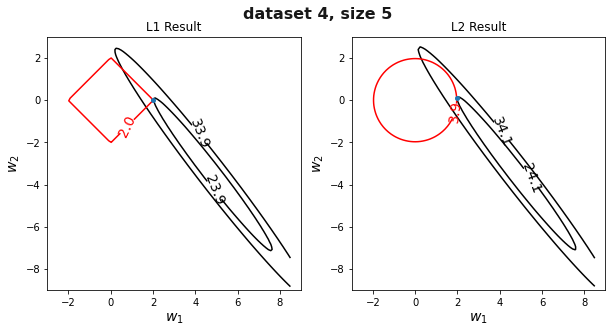

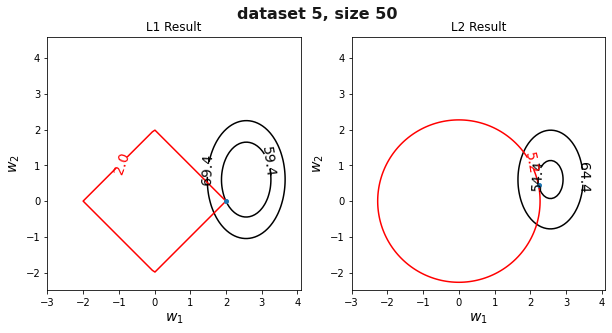

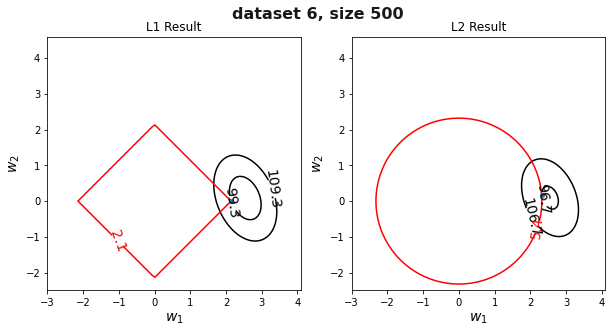

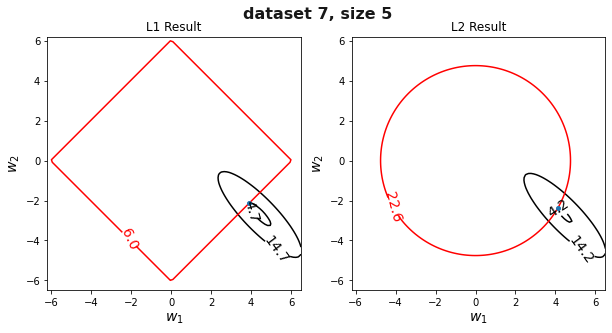

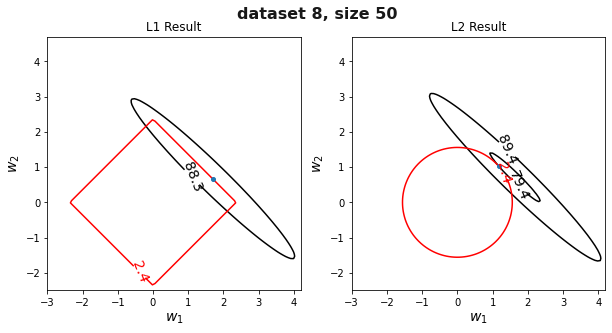

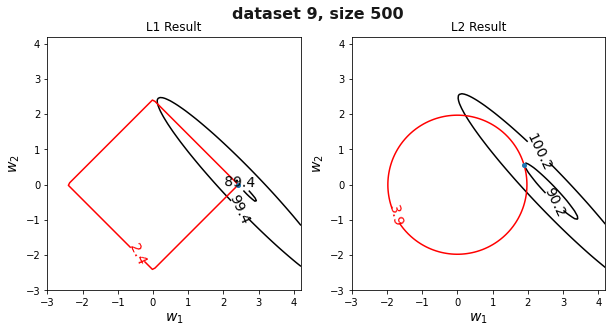

In [10]:
Xtrains = []
ytrains = []
for i in range(3, 9):
    Xtrains.append(np.concatenate((np.ones((len(data_list[i][0]), 1)),
                                         data_list[i][0]), axis=1))
    ytrains.append(data_list[i][1])

w1ranges = [(-3.0, 8.5, 100), (-3.0, 4.1, 100), (-3.0, 4.1, 100), 
(-6.2, 6.5, 100), (-3.0, 4.2, 100), (-3.0, 4.2, 100)]
w2ranges = [(-9.0, 3.0, 100), (-2.5, 3.0, 100), (-2.5, 3.0, 100),
(-6.5, 6.2, 100), (-2.5, 3.5, 100), (-3.0, 4.2, 100)]

sizes = [5, 50, 500]
for i in range(6):
    plotResult([table_list[i][1][-1], table_list[i][2][-1]], 
    Xtrains[i], ytrains[i], 
    w1_range=w1ranges[i], w2_range=w2ranges[i] ,
    figtitle=f'dataset {i+4}, size {sizes[i%3]}')


#### iii. Based on the statistics and plots, answer the following questions:

1. Observe and explain how the plots relate to sparsity.

It is difficult for Ridge regression to get sparsity, \
while it is easier for Lasso regression to lead to sparsity,\
when the contour of cost function reach the corner of a "diamond".

2. Can you explain how much effect the regularizer has, from looking at the
plots 

When $N_{tr}$ = 5, Ridge and Lasso both have a little large effect.\
However, when $N_{tr}$ =50, and 500, they both have small effect and the effects are close.

3. Observe and explain how Lasso has a different effect with the “special
case” datasets than the other datasets

For dataset 7 and 8, one of Lasso constrain line is parallel with \
tangential direction of contour of cost function, which leads to no sparsity

## 4. Comparison of loss functions in logistic regression (log exponential loss), perceptron, and mean-squared error criterion functions, for classification.

In [50]:
def lr_criterion(s):
    '''logistic regression'''
    return np.log(1+np.exp(-s))
def lp_criterion(s):
    '''2-class linear perceptron learning'''
    return -s * (s<=0)
def mse_criterion(s):
    '''MSE'''
    N = 12
    return (s-1)**2/N

def plot_criterion(criterion, figtitle, y_name):
    s = [np.linspace(-10, 10, 100), np.linspace(-2, 2, 100)]
    E = [criterion(s[0]), criterion(s[1])]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

    ax1.plot(s[0], E[0])
    ax2.plot(s[1], E[1])
    ax1.set_title('-10 to 10 Result')
    ax1.set_xlabel('$s$', fontsize = 14)
    ax1.set_ylabel(y_name, fontsize = 14)
    ax2.set_title('-2 to 2 Result')
    ax2.set_xlabel('$s$', fontsize = 14)
    fig.suptitle(t=figtitle,x=0.5,y=1.0,fontsize=16, alpha=0.9, weight='bold')
    plt.show()


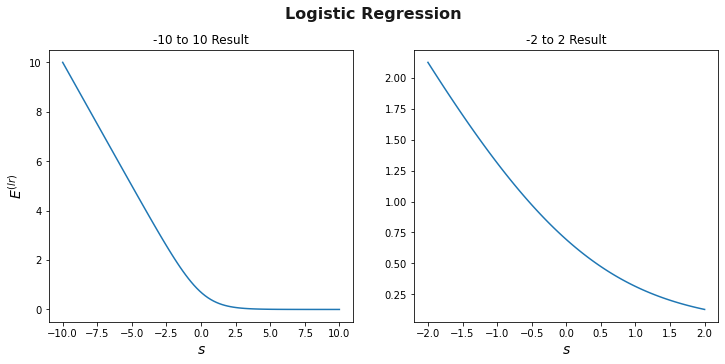

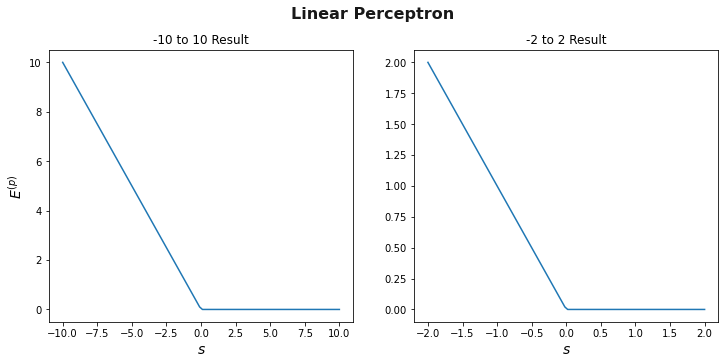

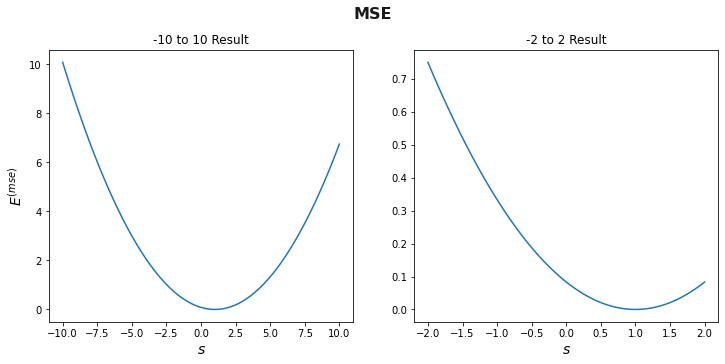

In [51]:
plot_criterion(lr_criterion, "Logistic Regression", '$E^{(lr)}$')
plot_criterion(lp_criterion, "Linear Perceptron", '$E^{(p)}$')
plot_criterion(mse_criterion, "MSE", '$E^{(mse)}$')